![picture](https://doc.google.com/uc?id=1-SCmtVCHxEXXpBfRMwvY_gBrDFA6Pb3u)

# Tomato Leaf Disease Type Classification with Tensorflow 2.0 

# Training Notebook

## Level: Beginner

In this short hands-on activity, you will build a simple cat neural network classifier with Tensorlow 2.0

1. Build a neural network that classifies vehicle types images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries ##

In [2]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys
#load the saved model
from keras.models import load_model

#check the version of tensorflow, make sure it version 2.0 and above
print (tf.__version__)

2.9.2


In [3]:
sys.path.append('/content/drive/MyDrive/TLDArchive2/')
import anis_koubaa_udemy_computer_vision_lib  
from anis_koubaa_udemy_computer_vision_lib import *

In [4]:
PROJECT_PATH='/content/drive/MyDrive/TLDArchive2/tomato2/'
print('PROJECT_PATH: ',PROJECT_PATH)
HDF5_DATASET_PATH=PROJECT_PATH+'h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5'
print(HDF5_DATASET_PATH)

PROJECT_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/
/content/drive/MyDrive/TLDArchive2/tomato2/h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5


## Loading the training data ##

In [5]:
def load_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")
  trainX= np.array(hf["trainX"]).astype("f8")
  ascii_train_labels = np.array(hf["trainLabels"]).astype("S40")
  trainY=np.array(hf["trainY"]).astype("int")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S40")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S40")
  testY=np.array(hf["testY"]).astype("int")

  trainLabels = np.array([n.decode('unicode_escape') for n in ascii_train_labels])
  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])

  print("trainX.shape: ",trainX.shape)
  print("trainY.shape: ",trainY.shape)
  print("trainLabels.shape: ",trainLabels.shape)
  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels

In [6]:
IMAGE_SIZE=224
import datetime
t0=datetime.datetime.now()
trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)
t1=datetime.datetime.now()
print("time to load the data: ",(t1-t0))

trainX.shape:  (8632, 224, 224, 3)
trainY.shape:  (8632, 10)
trainLabels.shape:  (8632,)
devX.shape:  (1079, 224, 224, 3)
devY.shape:  (1079, 10)
devLabels.shape:  (1079,)
testX.shape:  (1080, 224, 224, 3)
testY.shape:  (1080, 10)
testLabels.shape:  (1080,)
time to load the data:  0:01:03.090645


## Visualize Some Images ##

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


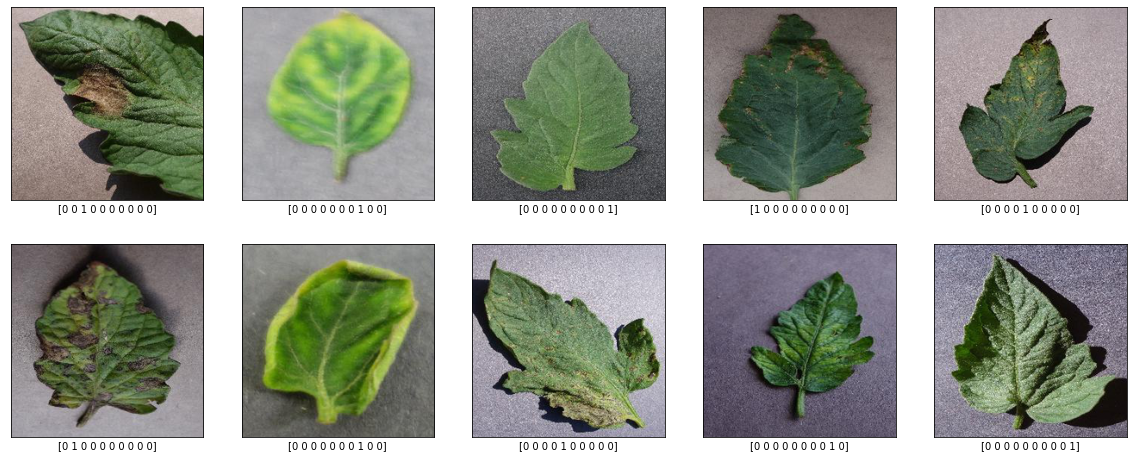

In [7]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainY,rows=2, colums=5, width=20,height=8)


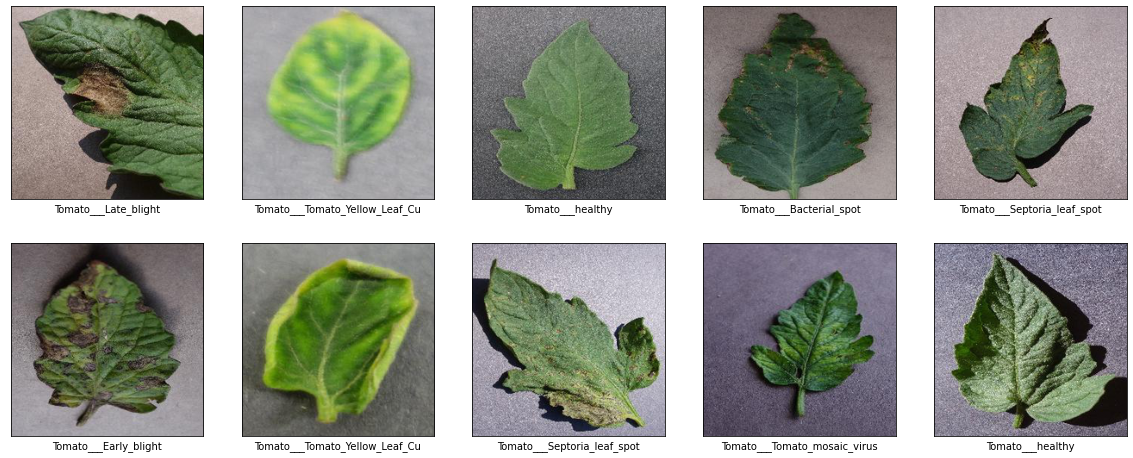

In [8]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainLabels,rows=2, colums=5, width=20,height=8)

## Building the Neural Network Model ##

Now that we have our dataset prepare, we are ready to create neural networks. 

We will create two types of networks. One fully connected neural networks, and one convolutional neural network.

If you do not have a background on covolutional neural networks, please refer to my online YouTube lecture https://www.youtube.com/watch?v=vibHourRAEc

## Create a convolutional neural network model

In [9]:
#import keras and its libraries
from tensorflow.keras import datasets, layers, models

def create_cnn_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', 
                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation = 'softmax'))
    
    return model

# Training with a convolutional neural network model

In [13]:
BATCH_SIZE=64
EPOCHS=200
LR=1e-4
BETA_1=0.9
BETA_2=0.999
EPSILON=1e-08
DECAY=LR/ EPOCHS

In [14]:
import tensorflow as tf
#from tensorflow.keras.optimizers import SGD
# import Adam
from tensorflow.keras.optimizers import Adam
print('creating model')
model = create_cnn_model()
opt= Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

creating model


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 110, 110, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [16]:
trainX.shape, trainY.shape, testX.shape, testY.shape  

((8632, 224, 224, 3), (8632, 10), (1080, 224, 224, 3), (1080, 10))

In [17]:
import datetime
print('training model')
t0=datetime.datetime.now()
history=model.fit(trainX, trainY, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          verbose=1, validation_data=(testX, testY))
t1=datetime.datetime.now()
print("time to train the model", (t1-t0))

training model
Epoch 1/200
135/135 [==============================] - 18s 48ms/step - loss: 1.5517 - accuracy: 0.4738 - val_loss: 3.0747 - val_accuracy: 0.1278
Epoch 2/200
135/135 [==============================] - 5s 36ms/step - loss: 0.9387 - accuracy: 0.7053 - val_loss: 2.9538 - val_accuracy: 0.2472
Epoch 3/200
135/135 [==============================] - 5s 36ms/step - loss: 0.7149 - accuracy: 0.7932 - val_loss: 2.5471 - val_accuracy: 0.2630
Epoch 4/200
135/135 [==============================] - 5s 36ms/step - loss: 0.5845 - accuracy: 0.8341 - val_loss: 1.1436 - val_accuracy: 0.6315
Epoch 5/200
135/135 [==============================] - 5s 35ms/step - loss: 0.4852 - accuracy: 0.8668 - val_loss: 0.7790 - val_accuracy: 0.7222
Epoch 6/200
135/135 [==============================] - 5s 36ms/step - loss: 0.4244 - accuracy: 0.8862 - val_loss: 0.4463 - val_accuracy: 0.8602
Epoch 7/200
135/135 [==============================] - 5s 36ms/step - loss: 0.3669 - accuracy: 0.9019 - val_loss: 0.4784

In [18]:
model.save(PROJECT_PATH+"td_model_cnn_adam.h5")
PROJECT_PATH


'/content/drive/MyDrive/TLDArchive2/tomato2/'

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_history(history):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Model Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Model Cross Entropy Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [22]:
print('Loading the best model...')
t0 = datetime.datetime.now()
test_model = tf.keras.models.load_model(PROJECT_PATH+"td_model_cnn_adam.h5")
t1 = datetime.datetime.now()
print('time to load the model: ', (t1-t0))

Loading the best model...
time to load the model:  0:00:01.722244


In [23]:
# make predictions on the validation set
print("[INFO] evaluating network on the dev dataset...")
test_model.evaluate(devX, devY,verbose=0)

[INFO] evaluating network on the dev dataset...


[0.2907909154891968, 0.9249305129051208]

In [24]:
print("[INFO] evaluating network on the test dataset...")
test_model.evaluate(testX, testY,verbose=0)

[INFO] evaluating network on the test dataset...


[0.36489203572273254, 0.9166666865348816]

In [25]:
# evaluate model
train_loss, train_acc = test_model.evaluate(trainX, trainY, verbose=0)
val_loss, val_acc = test_model.evaluate(devX, devY, verbose=0)
test_loss, test_acc = test_model.evaluate(testX, testY, verbose=0)
#	print('> %.3f' % (acc * 100.0))
print('Train Accuracy: %.3f, Validation Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc * 100.0, val_acc * 100.0, test_acc * 100.0))
print('Train Loss: %.3f, Validation Loss: %.3f, Test Loss: %.3f' % (train_loss, val_loss, test_loss))


Train Accuracy: 99.595, Validation Accuracy: 92.493, Test Accuracy: 91.667
Train Loss: 0.013, Validation Loss: 0.291, Test Loss: 0.365


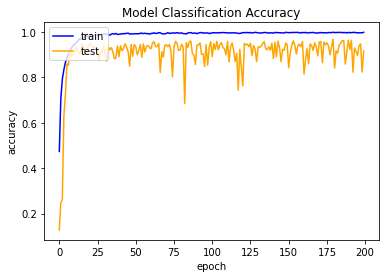

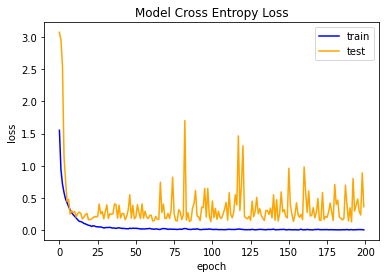

In [26]:
plot_history(history)

In [27]:
# What GPU I am assigned?
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 27 00:52:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    54W / 400W |  17964MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------